<a href="https://colab.research.google.com/github/SeroviICAI/Comprehensive_Optimization_of_Operations_in_the_Wood_Industry/blob/master/Comprehensive_Optimization_of_Operations_in_the_Wood_Industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Comprehensive Optimization of Operations in the Wood Industry</h1>
  <h3>Sergio Rodríguez, Álvaro Pereira and Jaime Paz</h3>
</div>

## What is the objective of this notebook?

**Welcome to this notebook!** The primary objective here is to explore and solve a series of **linear optimization problems specifically tailored to the Wood and Furniture Industry**. Through this journey, we’ll delve into various **real-world scenarios** where optimization can lead to increased efficiency, reduced waste, and overall improved performance in the industry. By understanding and applying linear optimization techniques, we aim to provide **valuable insights that can help make strategic decisions in the production, design, and distribution processes**.

Whether you’re a seasoned professional in the industry or a curious learner, this notebook offers **a practical and engaging way to understand and apply linear optimization** in the context of the Wood and Furniture Industry. **Let’s get started!**

## Setting Up the Environment: Importing Libraries and Installing Gurobi

In this section, we will be setting up our computational environment by importing necessary libraries and installing Gurobi. **Gurobi is a powerful optimization solver for mathematical programming**. It’s widely used in industry and academia for solving a variety of optimization problems including linear programming, quadratic programming, and mixed-integer programming.

To fully execute the code and follow along with this notebook, an **Academic Gurobi License is required**. Without this license, there is a **limit on the number of variables and constraints** that can be used in the optimization problems. **If you’re using a free license**, you may need to **adjust some parameters** to make the problems smaller and runnable within the constraints of the free license.

**Change the environment details (parameters) with those of your license:**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from matplotlib.lines import Line2D
import networkx as nx

import pandas as pd
import hashlib
import json

# Set the seed for reproducibility
import numpy as np
np.random.seed(40)

!pip install gurobipy>=10
import gurobipy as gp

# Create an environment with your WLS license
params = {
"WLSACCESSID": '1af7be00-c8f0-42f9-a6d5-c100e47b26ce',
"WLSSECRET": '94d7bc77-fc2c-4d43-b309-29df4204c650',
"LICENSEID": 2443502,
}
env = gp.Env(params=params)

## Minimizing Waste in Wood Stock Cutting

For this notebook we will use the **following dataset of wood types**. This dataset contains information such as **average price ($/m3) and density (kg/m3)**. This dataset was built upon the following document: https://www.timberconnection.co.uk/wp-content/uploads/2020/07/July-Stocklist-M3.pdf




In [ ]:
# @title Wooden Types Dataset

# https://www.timberconnection.co.uk/wp-content/uploads/2020/07/July-Stocklist-M3.pdf
wooden_types = [
    {
        "id": "WD-99fb9ed4",
        "name": "Oak",
        "avg_price_dollars_m3": 1304.89,
        "origin": "Europe",
        "weight_kg_m3": 730
    },
    {
        "id": "WD-dac37c9d",
        "name": "Beech",
        "avg_price_dollars_m3": 669.22,
        "origin": "Europe",
        "weight_kg_m3": 720
    },
    {
        "id": "WD-4a2f4a6f",
        "name": "Rustic Oak",
        "avg_price_dollars_m3": 1006.48,
        "origin": "Europe",
        "weight_kg_m3": 730
    },
    {
        "id": "WD-dbdaa73c",
        "name": "Prime Oak",
        "avg_price_dollars_m3": 2560.34,
        "origin": "Europe",
        "weight_kg_m3": 730
    },
    {
        "id": "WD-fd0c6b11",
        "name": "White Oak",
        "avg_price_dollars_m3": 1456.74,
        "origin": "North America",
        "weight_kg_m3": 755
    },
    {
        "id": "WD-65492874",
        "name": "Black Cherry",
        "avg_price_dollars_m3": 1128.31,
        "origin": "North America",
        "weight_kg_m3": 560
    },
    {
        "id": "WD-72c40f0f",
        "name": "Black Walnut",
        "avg_price_dollars_m3": 2251.33,
        "origin": "North America",
        "weight_kg_m3": 640
    },
    {
        "id": "WD-f3f01b29",
        "name": "White Maple",
        "avg_price_dollars_m3": 1269.57,
        "origin": "North America",
        "weight_kg_m3": 620
    },
    {
        "id": "WD-4dacb988",
        "name": "Yellow Pine",
        "avg_price_dollars_m3": 563.27,
        "origin": "North America",
        "weight_kg_m3": 570
    },
    {
        "id": "WD-25c4b833",
        "name": "Sapele",
        "avg_price_dollars_m3": 935.85,
        "origin": "Africa",
        "weight_kg_m3": 640
    },
    {
        "id": "WD-71180b29",
        "name": "Iroko",
        "avg_price_dollars_m3": 1304.89,
        "origin": "Africa",
        "weight_kg_m3": 660
    }
]

def get_avg_price_m3(wood_id):
    for wood in wooden_types:
        if wood['id'] == wood_id:
            return wood['avg_price_dollars_m3']
    raise ValueError(f"No wood found with id {wood_id}")

def get_weight_m3(wood_id):
    for wood in wooden_types:
        if wood['id'] == wood_id:
            return wood['weight_kg_m3']
    raise ValueError(f"No wood found with id {wood_id}")

pd.DataFrame(wooden_types)

,id,name,avg_price_dollars_m3,origin,weight_kg_m3
0,WD-99fb9ed4,Oak,1304.89,Europe,730
1,WD-dac37c9d,Beech,669.22,Europe,720
2,WD-4a2f4a6f,Rustic Oak,1006.48,Europe,730
3,WD-dbdaa73c,Prime Oak,2560.34,Europe,730
4,WD-fd0c6b11,White Oak,1456.74,North America,755
5,WD-65492874,Black Cherry,1128.31,North America,560
6,WD-72c40f0f,Black Walnut,2251.33,North America,640
7,WD-f3f01b29,White Maple,1269.57,North America,620
8,WD-4dacb988,Yellow Pine,563.27,North America,570
9,WD-25c4b833,Sapele,935.85,Africa,640


In the field of woodworking, **acquiring wood from sawmills is a fundamental first step**. However, it is not as simple as simply purchasing a random amount. The volume of wood required **depends on our ability to optimize the cutting process**, ensuring that each board is used efficiently. This economical approach **not only meets our demand but also promotes the sustainable use of resources**.

The challenge lies in cutting wood in a manner that **minimizes waste and maximizes the utility of the raw material**. This problem, known formally as the **‘Stock Cutting Problem’**, is a common issue faced in industries such as **woodworking, metalworking, and textiles**.

**Each piece of wood has 3 dimensions**. However, the problem presented in this section takes a **two-dimensional approach**, ignoring the height of the piece of wood. In other words, **all the pieces will be 15 cm high**.

The objective is to extract the **best piece cutting patterns from the original plank** (dimensions 300x100cm). Below are the **representations of each object in Python**:

In [ ]:
wooden_plank = {
    'id': None,
    'w': 300,
    'h': 100
}

pieces_types = [
    {
        'id': 'PE-59013a97',
        'w': 200,
        'h': 100
    },
    {
        'id': 'PE-9c0e875d',
        'w': 75,
        'h': 15
    },
    {
        'id': 'PE-1f0dcdf7',
        'w': 40,
        'h': 40
    },
    {
        'id': 'PE-d3120c64',
        'w': 35,
        'h': 15
    }
]

pattern_example = {
    'id': 'PT-de14a88d',
    'pieces': {
        'PE-59013a97': {
            'amount': 1,
            'position': {
                (0, 0)
            }
        },
        'PE-9c0e875d': {
            'amount': 0,
            'position': set()
        },
        'PE-1f0dcdf7': {
            'amount': 4,
            'position': {
                (240, 0),
                (240, 40),
                (200, 0),
                (200, 40)
            }
        },
        'PE-d3120c64': {
            'amount': 4,
            'position': {
                (280, 0),
                (280, 35),
                (240, 80),
                (200, 80)
            }
        }
    },
    'waste': 1500
}

An intuitive way to solve this problem is to compute **all the possible feasible patterns** to cut a plank so as to obtain different quantities of each piece, and find which combination of patterns **meets the demand and produces the minimum waste** (A feasible pattern has **a remaining area lower than any other piece area**).

### MaxRects 2-dimensional Bin Packing

<img align="right" width=420 src="https://d3i71xaburhd42.cloudfront.net/6274f70cbaf4dc4db40c667d99fabaac257e9260/7-Figure2-1.png">

**Imagine that the wooden plank is a box in which we want to put a number pieces in such a way that the wasted space is minimum**. This approach is known as **'Bin Packing'** and seeks a feasible way to introduce an n-dimensional set of parts into a given area. Computationally, the problem is **NP-hard**.

In our case, we will implement a simplified version of the **Maximal Rectangles (MaxRects) bin packing algorithm**, which is used to efficiently pack smaller rectangles into a larger one with the aim of minimizing wasted space. This algorithm is commonly used in various fields such as **computer graphics** (e.g., texture packing) **and operations research** (e.g., cutting stock problem).

The Python code below defines two classes: `Node` and `MaxRectsPacker`. The `Node` class represents a rectangular area or block. It has the following attributes:
* `x` and `y`: The coordinates of the top-left corner of the rectangle.
* `w` and `h`: The width and height of the rectangle.
* `used`: A boolean indicating whether the rectangle is used or not.

The `MaxRectsPacker` class is used to pack smaller rectangles (`blocks`) into a larger one. It has the following methods:
* `__init__(self, w, h)`: This is the constructor method. It initializes an instance of the class with a single available node representing the entire area (width `w` and height `h`).

* `fit(self, blocks)`: This method attempts to fit a list of `blocks` into the available nodes. For each block, it finds the smallest available node where the block fits. If such a node is found, it splits the node and removes it from the available nodes.

* `split_node(self, node, w, h)`: This method splits a `node` into two new nodes based on the width w and height h of a block. It marks the original node as used and adds the new nodes to the list of available nodes.

In [ ]:
class Node:
    def __init__(self, x, y, w, h, used=False):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.used = used

class MaxRectsPacker:
    def __init__(self, w, h):
        self.available = [Node(0, 0, w, h)]

    def fit(self, blocks):
        for block in blocks:
            # Find the smallest available node where the block fits
            node = min((node for node in self.available if block['w'] <= node.w and block['h'] <= node.h),
                       key=lambda node: node.w * node.h, default=None)
            if node:
                # If a node was found, split it and remove it from the available nodes
                self.split_node(node, block['w'], block['h'])
                self.available.remove(node)
                block['fit'] = node

    def split_node(self, node, w, h):
        # Split the node into two new nodes
        node.used = True
        self.available.append(Node(node.x + w, node.y, node.w - w, node.h))
        self.available.append(Node(node.x, node.y + h, w, node.h - h))

### Generating Cutting Patterns

You have probably already noticed that if we always pass the **same combination of pieces** to the fit function, the result will always be the **same pattern**. However, what happens if we **try all possible combinations of blocks whose sum is close to the area of ​​the original plank (close = remaining area smaller than smallest piece area)**? Then we would get **all the possible feasible patterns** (with unrepeated amounts of each piece).

For our algorithm to work correctly, we must **pass it a list of all the blocks that we want to adjust, ordered from largest to smallest area**. Following this list we will pass to `MaxRectsPacker` **a list of these same blocks rotated 90 degrees**. In addition, to ensure that we make the most of the area of ​​our wooden plank, we will always ask the algorithm to cut **extra pieces of the smallest possible size**.

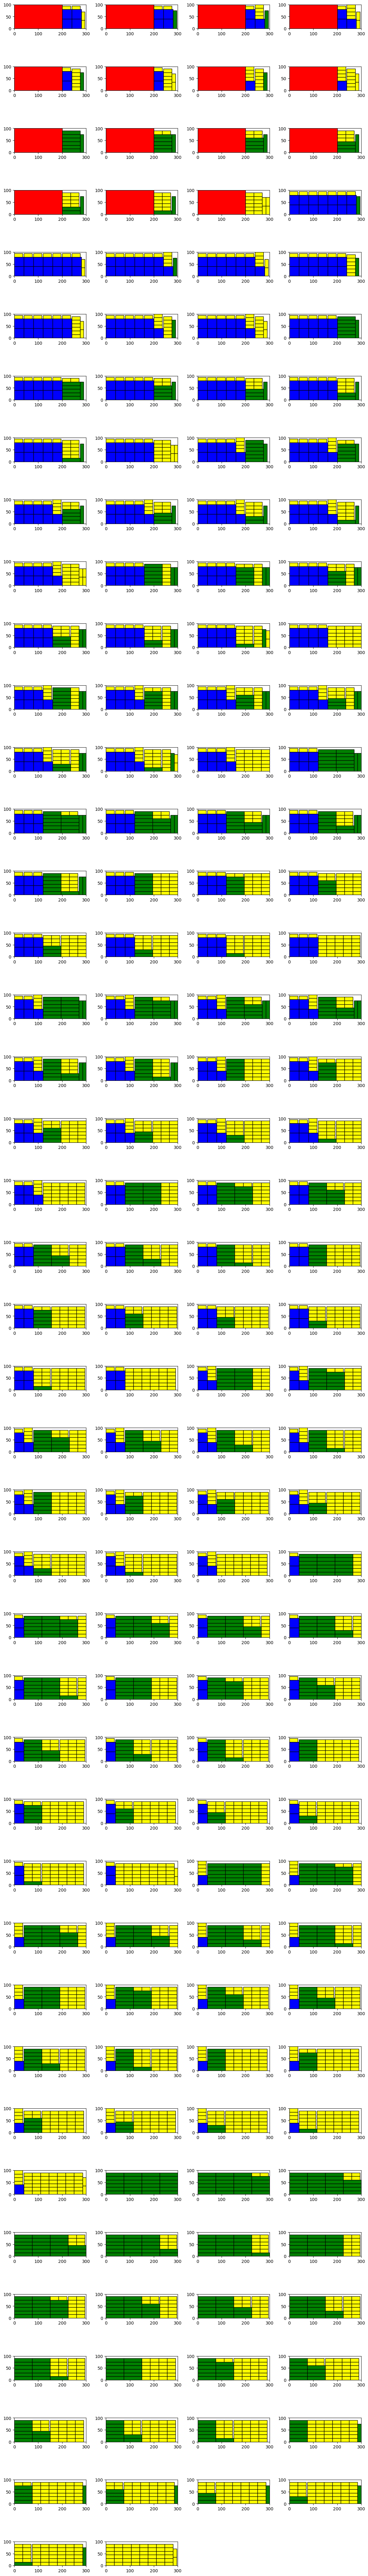

In [ ]:
# @title Python Code

def find_combinations(pieces, max_area):
    # Calculate the area of each piece
    for piece in pieces:
        piece['area'] = piece['w'] * piece['h']

    # Sort the pieces by area
    pieces.sort(key=lambda x: x['area'], reverse=True)

    # Initialize the list of combinations
    combinations = []

    # Helper function to find combinations
    def helper(area_left, combination, start):
        # If the remaining area is less than the area of the smallest piece, add the combination to the list
        if area_left < pieces[-1]['area']:
            combinations.append(combination)
            return

        # For each piece, try to add it to the combination
        for i in range(start, len(pieces)):
            if pieces[i]['area'] <= area_left:
                helper(area_left - pieces[i]['area'], combination + [pieces[i].copy()], i)

    # Call the helper function to start the search
    helper(max_area, [], 0)

    return combinations

# Define the pieces and the maximum area
max_area = wooden_plank['w'] * wooden_plank['h']

# Find all possible combinations
combinations = find_combinations(pieces_types, max_area)

# Define the colors for each type of piece
colors = {'PE-59013a97': 'red', 'PE-9c0e875d': 'green', 'PE-1f0dcdf7': 'blue', 'PE-d3120c64': 'yellow'}

# Initialize an empty list to store the patterns
patterns = []

# Initialize an empty list to store the pattern strings
pattern_pieces_strings = []

# Calculate the number of rows for the subplot grid
num_combinations = len(combinations)
num_columns = 4
num_rows = num_combinations // num_columns + 1

# Create a figure for all combinations
fig = plt.figure(figsize=(12, num_rows*2))
subplot_counter = 1

# Loop over combinations and axes together
for i, combination in enumerate(combinations):
    # Create an instance of MaxRectsPacker with the size of a wooden plank
    packer = MaxRectsPacker(wooden_plank['w'], wooden_plank['h'])

    # Add extra small pieces to fill in gaps
    combination += [{'id': 'PE-d3120c64', 'w': 35, 'h': 15, 'area': 35*15} for _ in range(20)]

    # Sort the blocks by area (width x height)
    combination = sorted(combination, key=lambda piece: piece['area'], reverse=True)
    combination += [{'id': piece['id'], 'w': piece['h'], 'h': piece['w'],
                    'area': piece['area']} for piece in combination]

    # Fit the pieces
    packer.fit(combination)

    # Initialize an empty pattern
    pattern_id = 'PT-' + hashlib.md5(('pattern' + str(i)).encode()).hexdigest()[:8]
    pattern = {
        'id': pattern_id,
        'pieces': {
            'PE-59013a97': {
                'amount': 0,
                'position': []
            },
            'PE-9c0e875d': {
                'amount': 0,
                'position': []
            },
            'PE-1f0dcdf7': {
                'amount': 0,
                'position': []
            },
            'PE-d3120c64': {
                'amount': 0,
                'position': []
            }
        },
        'waste': max_area
    }

    # Draw each piece
    for piece in combination:
        if 'fit' in piece:
            # Add piece to pattern
            pattern['pieces'][piece['id']]['amount'] += 1
            x, y = piece['fit'].x, piece['fit'].y
            pattern['pieces'][piece['id']]['position'].append((x, y))
            w, h = (piece['w'], piece['h'])
            pattern['waste'] -= w * h

    # Convert the pattern to a string
    pattern_pieces_string = json.dumps(pattern['pieces'], sort_keys=True)

    # Check if the pattern string is already in the list
    if pattern_pieces_string not in pattern_pieces_strings:
        # Save pattern figure
        patterns.append(pattern)
        pattern_pieces_strings.append(pattern_pieces_string)

        # Crear un nuevo subgráfico
        ax = fig.add_subplot(num_rows, num_columns, subplot_counter)
        ax.set(xlim=(0, wooden_plank['w']), ylim=(0, wooden_plank['h']), aspect='equal')
        subplot_counter += 1

        # Draw each piece
        for piece in combination:
            if 'fit' in piece:
                x, y = piece['fit'].x, piece['fit'].y
                w, h = (piece['w'], piece['h'])

                # Plot piece
                color = colors[piece['id']]  # Specific color for each type of piece
                ax.add_patch(patches.Rectangle((x, y), w, h, facecolor=color, edgecolor='black'))

plt.tight_layout()
plt.show()

# Save the patterns to a JSON file
with open('patterns.json', 'w') as f:
    json.dump(patterns, f, indent=4)

### Setting Parameters

In the following section we will try to optimize the patterns used to **meet the demand for pieces of each type of wood whilst minimizing waste**. The **output of our model** should be a list of **wooden planks that have been cut following an optimal pattern**. An example of a plank is shown below:

In [ ]:
plank_example = {
    'id': 'WD-71180b29-P001',
    'wood': 'WD-71180b29',
    'pattern': 'PT-de14a88d'
}

pieces = ['PE-59013a97', 'PE-9c0e875d', 'PE-1f0dcdf7', 'PE-d3120c64']

Let's say **the demand for chairs is three times greater than the demand for tables**. Additionally, let's create **a demand factor by which to divide the average price of each type of wood**, such that the demand for more expensive wood will be lower.

In [ ]:
# @title Needed pieces

# Sets, products and factories
maxPlanks = 100

# Initialize an empty dictionary of needed pieces
needed_pieces = {}

# Setting a price factor for simulating demand
price_factor = 30000

# For each wood type
for wood in wooden_types:
    # Calculate a demand factor based on the price of the wood
    demand_factor = price_factor / wood['avg_price_dollars_m3']

    # For each piece type
    for piece in pieces:
        # The demand for piece 1 is the demand factor
        if piece == 'PE-59013a97':
            needed_pieces[(piece, wood['id'])] = demand_factor
        # The demand for piece 2 is the demand factor divided by 4
        elif piece == 'PE-9c0e875d':
            needed_pieces[(piece, wood['id'])] = demand_factor / 4
        # The demand for piece 3 is 3 times the demand for piece 1
        elif piece == 'PE-1f0dcdf7':
            needed_pieces[(piece, wood['id'])] = 3 * demand_factor
        # The demand for piece 4 is 3 times the demand for piece 2
        else:   # elif piece == 'PE-d3120c64':
            needed_pieces[(piece, wood['id'])] = 3 * (demand_factor / 4)

        # Round the demand to the nearest integer
        needed_pieces[(piece, wood['id'])] = round(needed_pieces[(piece, wood['id'])])

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(needed_pieces.items()), columns=['Index', 'Demand'])

# Split the tuple index into two separate columns
df[['Piece', 'Wood']] = pd.DataFrame(df['Index'].tolist(), index=df.index)

# Drop the original 'Index' column
df = df.drop('Index', axis=1)

# Set 'Piece' and 'Wood' as the index
df.set_index(['Piece', 'Wood']).T

Piece,PE-59013a97,PE-9c0e875d,PE-1f0dcdf7,PE-d3120c64,PE-59013a97,PE-9c0e875d,PE-1f0dcdf7,PE-d3120c64,PE-59013a97,PE-9c0e875d,...,PE-1f0dcdf7,PE-d3120c64,PE-59013a97,PE-9c0e875d,PE-1f0dcdf7,PE-d3120c64,PE-59013a97,PE-9c0e875d,PE-1f0dcdf7,PE-d3120c64
Wood,WD-99fb9ed4,WD-99fb9ed4,WD-99fb9ed4,WD-99fb9ed4,WD-dac37c9d,WD-dac37c9d,WD-dac37c9d,WD-dac37c9d,WD-4a2f4a6f,WD-4a2f4a6f,...,WD-4dacb988,WD-4dacb988,WD-25c4b833,WD-25c4b833,WD-25c4b833,WD-25c4b833,WD-71180b29,WD-71180b29,WD-71180b29,WD-71180b29
Demand,23,6,69,17,45,11,134,34,30,7,...,160,40,32,8,96,24,23,6,69,17


### Optimizing Pattern Use
Remember the objective of this problem is to **minimize the waste in the use of different types of wood for various patterns and pieces**. The problem is formulated with sets, parameters, variables, an objective function, and constraints:

<h4><strong>SETS</strong></h4>

Firstly, necessary sets are defined:
* $m$: different types of wood (`wooden_types`)
* $j$: different patterns (`patterns`)
* $p$: different pieces (`pieces`)

<h4><strong>PARAMETERS</strong></h4>

The problem has some known values related with the wood or the goals.
* $waste_{j}$: indicates the waste for pattern j (`patterns[j]['waste']`)
* $amount\_pieces_{p, j}$: indicates the amount of piece p in pattern j (`patterns[j]['pieces'][p]['amount']`)
* $needed\_pieces_{p, m}$: indicates the needed pieces for each piece p and wood type m (`needed_pieces[p['id'], m['id']`)
* $maxPlanks$: maximum number of planks (`maxPlanks`)

<h4><strong>VARIABLES</strong></h4>

Once known values are assigned, variables of the model must be defined.

* $use\_plank_{j,i}$: indicates if plank i uses pattern j (`use_plank[j, i]`)

<h4><strong>OBJECTIVE FUNCTION</strong></h4>

The objective function aims to minimize the waste.
This information leads to the following equation:

<center>$min(\sum_j​\sum_{i=1}^{maxPlanks}waste_{j}∗use\_plank_{j,i})$</center>

Which translated to code is:

`(gp.quicksum(patterns[j]['waste']*use_plank[j, i] for j in range(len(patterns)) for i in range(maxPlanks))`

<h4><strong>CONSTRAINTS</strong></h4>

Our problem operates within certain boundaries. These constraints ensure that all decisions made are feasible and practical.

The first constraint assures the needed pieces for each piece and wood type:
<center>
$\sum_j​\sum_{i=1}^{maxPlanks}​use\_plank_{j,i}∗amount\_pieces_{p, j} \geq needed\_pieces_{p, m} \quad \forall p$

`(gp.quicksum(use_plank[j, i] * patterns[j]['pieces'][p]['amount'] for j in range(len(patterns)) for i in range(maxPlanks)) >= needed_pieces[p['id'], m['id']])`
</center>

The second constraint ensures that each plank uses at most one pattern:

<center>
$\sum_j​use\_plank_{j,i} \leq 1 \quad \forall i$

`(gp.quicksum(use_plank[j, i] for j in range(len(patterns))) <= 1)`
</center>

Last constraint is to limit the variables to be binary

<center>​$use\_plank \in \{0,1\}$</center>

In the code, these constraints are set when creating variables (for example with flag `gp.GRB.BINARY`)

In [ ]:
# Create the output
planks = []

# Solve the problem for each wood type separately
for m in wooden_types:
    # Create a new model
    model = gp.Model(env=env)

    # Silence the model
    model.setParam('OutputFlag', 0)

    # Creating variables
    use_plank = {}
    for j in range(len(patterns)):
        for i in range(maxPlanks):
            use_plank[(j, i)] = model.addVar(vtype=gp.GRB.BINARY, name='use_plank[%i,%i]' % (j, i))

    # Objective function
    model.setObjective(gp.quicksum(patterns[j]['waste']*use_plank[j, i] for j in range(len(patterns)) for i in range(maxPlanks)), gp.GRB.MINIMIZE)

    # Constraints
    for p in pieces:
        model.addConstr(gp.quicksum(use_plank[j, i] * patterns[j]['pieces'][p]['amount'] for j in range(len(patterns)) for i in range(maxPlanks)) >= needed_pieces[p, m['id']])

    for i in range(maxPlanks):
        model.addConstr(gp.quicksum(use_plank[j, i] for j in range(len(patterns))) <= 1)

    # Solve the problem
    model.optimize()

    # Add the results to the output
    for i in range(maxPlanks):
       for j in range(len(patterns)):
          if use_plank[j, i].x > 0:
              planks.append({
                  'id': m['id'] + '-P' + str(i).zfill(3),
                  'wood': m['id'],
                  'pattern': patterns[j]['id']
              })

# Save the planks to a JSON file
with open('planks.json', 'w') as f:
    json.dump(planks, f, indent=4)

## Cost-Effective Truck Acquisition for Maximum Capacity

The lumber warehouse and sawmills are located in different locations. This is why a fleet of trucks is needed to transport planks from sawmills to a central warehouse. Below is a list of all the **available models** to choose from:

In [ ]:
# @title European Truck Dataset
european_trucks = [
    {
        "id": "TR-811ebab8",
        "name": "Renault Trucks D Wide Z.E. 26t",
        "price": 120000,
        "weight_capacity_kg": 13000
    },
    {
        "id": "TR-ea8ff7d7",
        "name": "Mercedes-Benz eActros 25t",
        "price": 150000,
        "weight_capacity_kg": 11000
    },
    {
        "id": "TR-e20cdcb5",
        "name": "Volvo FL Electric 16t",
        "price": 110000,
        "weight_capacity_kg": 8000
    },
    {
        "id": "TR-2aecfa63",
        "name": "MAN eTGM 26t",
        "price": 140000,
        "weight_capacity_kg": 12000
    },
    {
        "id": "TR-d5b7fe4a",
        "name": "Iveco Eurocargo Electric 12t",
        "price": 100000,
        "weight_capacity_kg": 6000
    },
    {
        "id": "TR-22166854",
        "name": "DAF LF Electric 19t",
        "price": 130000,
        "weight_capacity_kg": 9000
    }
]

def get_weight_capacity(truck_model_id):
    for truck in european_trucks:
        if truck['id'] == truck_model_id:
            return truck['weight_capacity_kg']
    raise ValueError(f"No truck found with id {truck_model_id}")

pd.DataFrame(european_trucks)

,id,name,price,weight_capacity_kg
0,TR-811ebab8,Renault Trucks D Wide Z.E. 26t,120000,13000
1,TR-ea8ff7d7,Mercedes-Benz eActros 25t,150000,11000
2,TR-e20cdcb5,Volvo FL Electric 16t,110000,8000
3,TR-2aecfa63,MAN eTGM 26t,140000,12000
4,TR-d5b7fe4a,Iveco Eurocargo Electric 12t,100000,6000
5,TR-22166854,DAF LF Electric 19t,130000,9000


In [ ]:
truck_example = {
    'id': 'TR-811ebab8-U001',
    'model': 'TR-811ebab8'
}

### Optimizing Truck Selection

We need a fleet of trucks to **transport the wood from the sawmills to the factories**. There are different types of trucks we can choose, each one with some characteristics such as price or capacity.

Our task is to **find the cheapest fleet which can transport the highest amount of wood**. There is a minimum capacity needed, an optimal capacity to reach and a budget we want to keep to.

That's why a **goal programming aproach** was chosen, where both attributes are weighted with a with a weight parameter, which gives more importance to some variables but also helps balancing both attributes (prices are one order over capacity).

The **formal formulation** of this problem is the following:

<h4><strong>SETS</strong></h4>

Firstly, necessarly sets are defined:
* $t$: different types of trucks `(european_trucks)`
* $a$: attributes taken in count `(attributes)`

<h4><strong>PARAMETERS</strong></h4>

The problem has some known values related with the trucks or the goals.
* $A_{t,a}$: indicates the value of attribute $a$ for trucks of type $t$ `(trucks_attributes)`
* $W_a$: indicates the weight set for attribute $a$ `(weigths)`
* $GOAL_a$: indicates the goals for each attribute $a$ `(goals)`
* $MINC$: minimum capacity for the fleet `(minc)`

<h4><strong>VARIABLES</strong></h4>

Once known values are assigned, variables of the model must be defined.
* $x_t$: indicates how many trucks of type $t$ are bought `(trucks_selected)`
* $p_a$: positive deviations from attribute $a$ `(positive_deviation)`
* $n_a$: negative deviations from attribute $a$ `(negative_deviation)`

<h4><strong>OBJECTIVE FUNCTION</strong></h4>

The objective function aims to **minimize the deviation from our goals**. As we want to maximize total capacity, we must minimize the negative deviation from capacity goal. Additionally, as we want to minimize the price, we must minimize the positive deviation.

This information leads to the following equation:

<center>$min(W_p*p_p + W_c*n_c)$</center>

Which translated to code is:

`(weights['price']*positive_deviation['price'] + weights['weight_capacity_kg']*negative_deviation['weight_capacity_kg'])`

<h4><strong>CONSTRAINTS</strong></h4>

Our problem operates within certain boundaries. These constraints ensure that all decisions made are feasible and practical.
* The first constraint assures the minimum capacity for the fleet:
<center>
$\sum_tx_t*A_{t,c} \geq MINC$

`(gp.quicksum(trucks_attributes[(t['id'], 'weight_capacity_kg')]*trucks_selected[t['id']] for t in european_trucks) >= minc)`
</center>

* Following constraint sets both deviations from attributes goals

<center>
$\sum_tx_t*A_{t, a} - p_a + n_a = GOAL_a \quad \forall a$

`(positive_deviation[a] = model.addVar(vtype=gp.GRB.CONTINUOUS, name='positive_deviation[%s]' % a))`

`(negative_deviation[a] = model.addVar(vtype=gp.GRB.CONTINUOUS, name='negative_deviation[%s]' % a))`
</center>

* Last contraint is to limitate the variables to be positive

<center>$p_a, n_a, x_t \geq 0$</center>

In the code, these constraints are set when creating variables (for example with flag `gp.GRB.INTEGER`)

In [ ]:
# Create the model
model = gp.Model(env=env)

# Silence the model
model.setParam('OutputFlag', 0)

# Sets, products and factories
attributes = ['price', 'weight_capacity_kg']

# Setting parameters
trucks_attributes = { (t['id'], a): t[a] for t in european_trucks for a in attributes }

weights = {
    'price': 0.1,
    'weight_capacity_kg': 1,
}

# Calculate the total price and weight capacity of all trucks
total_price = sum(t['price'] for t in european_trucks)
total_weight_capacity = sum(t['weight_capacity_kg'] for t in european_trucks)

# Increase the capacity by a factor of 30 (or any other factor that suits your need)
increased_budget_factor = 20
increased_capacity_factor = 30

goals = {
    'price': increased_budget_factor * total_price / len(european_trucks),
    'weight_capacity_kg': increased_capacity_factor * total_weight_capacity / len(european_trucks),
}

minc = price_factor*3

# Creating variables
trucks_selected = {}
for t in european_trucks:
    trucks_selected[t['id']] = model.addVar(vtype=gp.GRB.INTEGER, name='trucks_selected[%s]' % t['id'])

positive_deviation = {}
negative_deviation = {}
for a in attributes:
    positive_deviation[a] = model.addVar(vtype=gp.GRB.CONTINUOUS, name='positive_deviation[%s]' % a)
    negative_deviation[a] = model.addVar(vtype=gp.GRB.CONTINUOUS, name='negative_deviation[%s]' % a)

# Objective function
model.setObjective(weights['price']*positive_deviation['price'] + weights['weight_capacity_kg']*negative_deviation['weight_capacity_kg'] , gp.GRB.MINIMIZE)

# Constraints
model.addConstr(gp.quicksum(trucks_attributes[(t['id'], 'weight_capacity_kg')]*trucks_selected[t['id']] for t in european_trucks) >= minc)

for a in attributes:
    model.addConstr(gp.quicksum(trucks_attributes[(t['id'], a)]*trucks_selected[t['id']] for t in european_trucks) + negative_deviation[a] - positive_deviation[a] == goals[a])

# Solve the problem
model.optimize()

# Create the output
trucks = []
for t in european_trucks:
    if trucks_selected[t['id']].x > 0:
        for unit_num in range(1, int(trucks_selected[t['id']].x) + 1):
            trucks.append({
                'id': t['id'] + '-U' + str(unit_num).zfill(3),
                'model': t['id']
            })

# Save the trucks to a JSON file
with open('trucks.json', 'w') as f:
    json.dump(trucks, f, indent=4)

## Logistics Problem: Purchase and transportation of wood to the Warehouse

Now, being clear about the amount of wood to be purchased and having trucks to transport it, it remains to define **where to buy the planks from and what routes our trucks will follow to collect the wood**. Suppose there are a total of **10 well-known sawmills** in the country:

In [ ]:
# Sets, products and factories
sawmills = ["Sawmill " + chr(65 + i) for i in range(8)]
trucks = trucks
planks = planks

### Creating map and routes

First of all, we need to create **a map with the sawmills and central warehouse** from which to calculate the **cost per route** from the warehouse to each sawmill. A quick way to create a map is to use **a random heatmap array**. Next, we place the **sawmills in random positions** on the map and the **warehouse in the center** of the map.

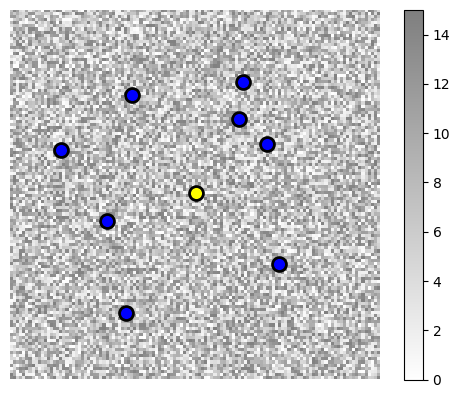

In [ ]:
# @title Map Generation with Random Heatmap
np.random.seed(23)

# Set the size of the map
size = 120

# Generate a random temperature map
cost_multiplier = 15
temperature_map = cost_multiplier * np.random.rand(size, size)

# Create a graph from the temperature map
G = nx.grid_2d_graph(size, size)

# Assign weights to the edges based on the temperature map
for (node1, node2) in G.edges():
    G[node1][node2]['weight'] = temperature_map[node1] + temperature_map[node2]

# Generate random coordinates for the sawmills
sawmill_coords = [tuple(x) for x in np.random.randint(
    15, size-15,size=(len(sawmills), 2))]

# Set the coordinates for the central warehouse
central_warehouse_coords = tuple(np.array([size // 2, size // 2]))

# Draw the temperature map
map = plt.imshow(temperature_map, cmap='binary', interpolation='nearest',
                 vmin=0, vmax=cost_multiplier, alpha=0.5)

# Draw the sawmills
plt.scatter(*zip(*[(x[1], size - x[0] - 1) for x in sawmill_coords]), s=100,
            color='blue', linewidth=2, edgecolors="black", label='Sawmills')

# Draw the central warehouse
plt.scatter(central_warehouse_coords[1], size - central_warehouse_coords[0] - 1,
            s=100, color='yellow', linewidth=2, edgecolors="black",
            label='Central Warehouse')

# Plot colorbar
plt.colorbar(map, orientation="vertical")
plt.axis('off')

# Show the plot
plt.show()

**Let's assume that all trucks have a similar consumption of about 20l/100km**. On the map we have generated, going through each square has a different cost. To find the closest route to each sawmill we can use **Dijkstra's Shortest Path Algorithm**.

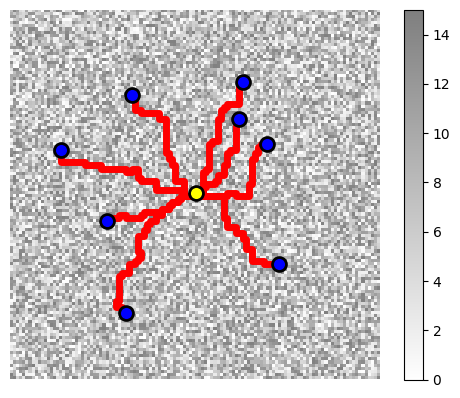

In [ ]:
# @title Route Calculation using Dijkstra's Algorithm

# Dictionary to store the cost for each route
routeCosts_sawmill = {}

# Calculate and plot shortest path from each sawmill to the central warehouse
for i, sawmill in enumerate(sawmill_coords):
    path = nx.dijkstra_path(G, source=sawmill, target=central_warehouse_coords,
                            weight='weight')
    path_coords = np.array(path)
    plt.plot(path_coords[:, 1], size - path_coords[:, 0] - 1, color='red',
             linewidth=5)

    # Calculate the cost for the route
    cost = sum(G[path[i]][path[i + 1]]['weight'] for i in range(len(path) - 1))

    # Save the cost in the dictionary
    routeCosts_sawmill[sawmills[i]] = cost

# Draw the temperature map
map = plt.imshow(temperature_map, cmap='binary', interpolation='nearest',
                 vmin=0, vmax=cost_multiplier, alpha=0.5)

# Draw the sawmills
plt.scatter(*zip(*[(x[1], size - x[0] - 1) for x in sawmill_coords]), s=100,
            color='blue', linewidth=2, edgecolors="black", label='Sawmills',
            zorder=3)

# Draw the central warehouse
plt.scatter(central_warehouse_coords[1], size - central_warehouse_coords[0] - 1,
            s=100, color='yellow', linewidth=2, edgecolors="black",
            label='Central Warehouse', zorder=3)

# Plot colorbar
plt.colorbar(map, orientation="vertical")
plt.axis('off')

# Show the plot
plt.show()

The chosen routes are the shortest routes between the sawmill and the warehouse **for all trucks**.

### Setting Parameters

In the previous section we **calculated the shortest route from each Sawmmill with Dijkstra**. The costs of each route are shown in the following table:

In [ ]:
# @title Route Cost from central warehouse to each sawmill
pd.Series(routeCosts_sawmill).to_frame().rename(columns={0: 'Route Cost'}).T

,Sawmill A,Sawmill B,Sawmill C,Sawmill D,Sawmill E,Sawmill F,Sawmill G,Sawmill H
Route Cost,516.686939,402.102834,337.500501,443.152275,473.590515,426.335404,340.006701,311.18336


Additionally, for this section we will need to **create a lumber price table for each sawmill**. This table will contain prices **sampled randomly from a normal distribution** centered on the average price of each type of wood and with a standard deviation of, say, 100. In addition, a **small probability (10%) is introduced that a sawmill does not process some types of wood** (in other words, their price is **infinite**).

In [ ]:
# @title Wood Price at each Sawmill
np.random.seed(32)

# Initialize the price_sawmill_wood dictionary
price_sawmill_wood = {}

for sawmill in sawmills:
    price_sawmill_wood[sawmill] = {}
    for wood in wooden_types:
        # Get the mean price of the wood
        mean_price = wood["avg_price_dollars_m3"]
        # Generate a random price based on a normal distribution with a standard deviation of 100
        random_price = np.random.normal(mean_price, 100)

        # Add a 10% chance that the sawmill does not have this type of wood
        if np.random.rand() < 0.1:
            random_price = float('inf')
              # Represent "no wood" as infinite cost

        # Add the price to the price_sawmill_wood dictionary, rounding to 2 decimal places
        price_sawmill_wood[sawmill][wood["id"]] = round(random_price, 2)

# Convert the price_sawmill_wood dictionary to a pandas DataFrame
pd.DataFrame(price_sawmill_wood)

,Sawmill A,Sawmill B,Sawmill C,Sawmill D,Sawmill E,Sawmill F,Sawmill G,Sawmill H
WD-99fb9ed4,1270.00,1396.59,1398.70,1245.82,1482.21,1390.17,1343.81,1235.72
WD-dac37c9d,767.59,719.78,inf,714.60,768.08,839.34,inf,728.25
WD-4a2f4a6f,1084.23,924.95,827.69,828.15,976.38,1017.93,970.45,1182.44
WD-dbdaa73c,2618.54,2564.30,2475.17,2660.21,2521.28,2532.27,2515.07,2681.82
WD-fd0c6b11,inf,1403.94,1462.05,1529.28,inf,1340.76,1307.29,1449.37
WD-65492874,1294.63,1237.07,1157.28,1017.05,1140.54,1187.75,1303.27,1207.99
WD-72c40f0f,2181.84,2318.67,2264.38,2252.58,2112.57,2260.01,inf,2207.94
WD-f3f01b29,1463.61,1605.94,1251.04,1415.56,1222.87,1138.40,inf,inf
WD-4dacb988,505.79,480.04,711.71,699.93,441.52,inf,511.85,537.20
WD-25c4b833,947.27,935.93,1067.16,889.86,976.18,936.25,697.98,984.21


Other important data sets for this problem are the **optimized results computed in previous sections**.

In [ ]:
weightm3_wood = {wood["id"]: get_weight_m3(wood["id"]) for wood in wooden_types}

weightCapacity_truck = {truck["id"]: get_weight_capacity(truck["model"]) for truck in trucks}

numberTrucks = len(trucks)

woodPlankSize = (wooden_plank['w'], wooden_plank['h'], 15)  # Adding 'height'

woodPlankVolume = np.prod(woodPlankSize)/1e6  # In cubic meters

### Optimizing Costs

In this optimization problem, there is a large variety of wood planks, categorized by type (obtained from the Wood Cutting problem). **These planks are found at different sawmills and each offers a unique price for each type of wood.**

We have **a fleet of trucks** (obtained from the truck choice problem), **each with its own loading capacity**, which will help us efficiently transport the wooden planks. Routes from each sawmill to the warehouse are already calculated (obtained from Route Calculation) each one with its own cost.

The goal is to make strategic decisions on **which planks to purchase at each sawmill and which trucks to send to each sawmill**. All these decisions need to be made in a way that **minimizes the total cost of wood and transportation from the sawmill to the warehouse**.

The **formal formulation** of this problem is the following:

<h4><strong>SETS</strong></h4>

The stage for this problem is set by various sets/categories:

* $s$: different sawmills `(sawmills)`
* $t$: different trucks bought `(trucks)`
* $p$: plank index `(planks)`

Following sets are indirectly referenced
* $w$: wood type `(wood)`


<h4><strong>PARAMETERS</strong></h4>

The are some known values that shape the problem and its constrains. Multiple of them were calculated in previous problems:

* $R_s$: route costs from/to sawmill $s$ `(routeCosts_sawmill)`
* $P_{s, w}$: cost of wood of type $w$ in sawmill $s$ `(price_sawmill_wood)`
* $W_t$: weight capacity of truck $t$
* $\rho_w$: density of each type of wood `(weightm3_wood)`
* $V$: plank volume `(woodPlankVolume)`

<h4><strong>VARIABLES</strong>

The dynamic elements of our problem are represented by variables. They capture decisions like which planks to select and where to buy them and which trucks to use:
* $x_{t, s}$: if truck $t$ is sent to sawmill $s$. This is important to calculate route costs `(send_truck_sawmill)`
* $y_{p, t, s}$: if plank $p$ is loaded into truck $t$ on sawmill $s$. We assume that any plank loaded was previously bought `(load_plank_truck_sawmill)`

<h4><strong>OBJECTIVE FUNCTION</strong>

The objective function aims to minimize the total cost, which includes the price of the wood and the transportation cost. This cost is a sum of two components:

<center>$min(\sum_{t, s}x_{t, s}*R_s*2 + \sum_{p, s, t} y_{p, t, s}*P_{s, w})$</center>

First component refers to route costs. It is multiplied by two in order to count both travelling to sawmills an travelling back to the central warehouse. The second component models the purchase of the wood.

This function translated to code is:

`(gp.quicksum(send_truck_sawmill[t['id'], s] * 2 * routeCosts_sawmill[s] for t in trucks for s in sawmills) + gp.quicksum(load_plank_truck_sawmill[p['id'], t['id'], s] * price_sawmill_wood[s][p['wood']] for p in planks for t in trucks for s in sawmills))`

<h4><strong>CONSTRAINTS</strong>

Our problem operates within certain boundaries. These constraints ensure that all decisions made are feasible and practical.

<ul>
<li> The first one forces the model to buy all planks calculated in <strong>Wood cutting problem</strong>:
<center>
$\sum_{t, s}y_{p, t, s} = 1 \quad\forall p$

`(gp.quicksum(load_plank_truck_sawmill[p['id'], t['id'], s] for t in trucks for s in sawmills) == 1)`
</center>
</li>

<li> The next ones refer to trucks limitations:
  <ul>
  <li> Each truck goes at most to one sawmill:

  <center>
  $\sum_{s}x_{t, s} \leq 1 \quad\forall t$

  `(gp.quicksum(send_truck_sawmill[t['id'], s] for s in sawmills) <= 1)`
  </center>
  </li>

  <li> Truck load cannot exceed its maximum capacity (reminder that each plank has an asociated wood type):

  <center>
  $\sum_{p, s}y_{p, t, s}*\rho_w*V \leq W_t \quad\forall t$

  `(gp.quicksum(load_plank_truck_sawmill[p['id'], t['id'], s] * weightm3_wood[p['wood']] * woodPlankVolume for p in planks for s in sawmills) <= weightCapacity_truck[t["id"]])`
  </center>
  </li>

  <li> The following one ensures that a truck can only load planks from the sawmill it was sent to. For this constraint a value $M$, pointing to infinite, is defined.

  <center>
  $\sum_{p}y_{p, t, s} \leq M*x_{t, s} \quad\forall t, s$

  `(gp.quicksum(load_plank_truck_sawmill[p['id'], t['id'], s] for p in planks) <= M*send_truck_sawmill[t['id'], s])`
  </center>
  </li>
  </ul>

</li>

<li> Finally, both variables are binary
<center>​$y_{p, t, s}, x_{t, s} \in \{0,1\}$</center>
</li>

</ul>

In [ ]:
# Create the model
model = gp.Model(env=env)

# Silence the model
model.setParam('OutputFlag', 0)

# Create a M value for the model
M = 1e5
# Create variables
# buy_plank_sawmill = model.addVars([(p['id'], s) for p in planks for s in sawmills], vtype=gp.GRB.BINARY, name="z")
send_truck_sawmill = model.addVars([(t['id'], s) for t in trucks for s in sawmills], vtype=gp.GRB.BINARY, name="x")
load_plank_truck_sawmill = model.addVars([(p['id'], t['id'], s) for p in planks for t in trucks for s in sawmills], vtype=gp.GRB.BINARY, name="y")

# Replace inf costs with a large finite value of 1e10 for compatibility with Gurobi.
for sawmill in sawmills:
    for wood_id in price_sawmill_wood[sawmill]:
        if price_sawmill_wood[sawmill][wood_id] == float('inf'):
            price_sawmill_wood[sawmill][wood_id] = M

# Objective function
model.setObjective(
    gp.quicksum(send_truck_sawmill[t['id'], s] * 2 * routeCosts_sawmill[s] for t in trucks for s in sawmills) +
    gp.quicksum(load_plank_truck_sawmill[p['id'], t['id'], s] * price_sawmill_wood[s][p['wood']] for p in planks for t in trucks for s in sawmills),
    gp.GRB.MINIMIZE
)

# Constraints
# Each plank need to be bought from a sawmill
for p in planks:
    model.addConstr(gp.quicksum(load_plank_truck_sawmill[p['id'], t['id'], s] for t in trucks for s in sawmills) == 1)

# Each truck can go to at most one sawmill
for t in trucks:
    model.addConstr(gp.quicksum(send_truck_sawmill[t['id'], s] for s in sawmills) <= 1)

# The load a truck carries cannot exceed its capacity
for t in trucks:
    model.addConstr(gp.quicksum(load_plank_truck_sawmill[p['id'], t['id'], s] * weightm3_wood[p['wood']] * woodPlankVolume for p in planks for s in sawmills) <= weightCapacity_truck[t["id"]])

# Each truck can only load planks from the sawmill it was sent
for t in trucks:
    for s in sawmills:
        model.addConstr(gp.quicksum(load_plank_truck_sawmill[p['id'], t['id'], s] for p in planks) <= M*send_truck_sawmill[t['id'], s])


# Solve the problem
model.optimize()

# After optimizing the model, create the output list
output = []

# For each truck
for t in trucks:
    # For each sawmill
    for s in sawmills:
        # If the truck is sent to the sawmill
        if send_truck_sawmill[t['id'], s].x > 0.5:
            # Create a dictionary for the truck and its load
            truck_load = {
                'truck': t['id'],
                'sawmill': s,
                'load': {
                    'weight': 0,
                    'planks': []
                }
            }
            # For each plank
            for p in planks:
                # If the plank is loaded onto the truck
                if load_plank_truck_sawmill[p['id'], t['id'], s].x > 0.5:
                    # Add the plank to the truck's load
                    truck_load['load']['planks'].append(p['id'])
                    # Add the weight of the plank to the total weight
                    truck_load['load']['weight'] += weightm3_wood[p['wood']] * woodPlankVolume
            # Add the truck and its load to the output list
            output.append(truck_load)

# Save the output to a JSON file
with open('logistics.json', 'w') as f:
    json.dump(output, f, indent=4)

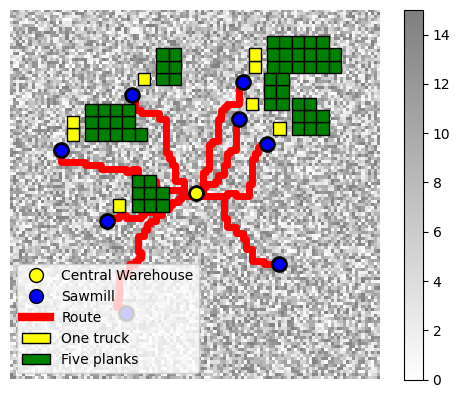

In [ ]:
# @title Plotting Output

fig, ax = plt.subplots()

# Dictionary to store the cost for each route
routeCosts_sawmill = {}

# Calculate and plot shortest path from each sawmill to the central warehouse
for i, sawmill in enumerate(sawmill_coords):
    path = nx.dijkstra_path(G, source=sawmill, target=central_warehouse_coords,
                            weight='weight')
    path_coords = np.array(path)
    ax.plot(path_coords[:, 1], size - path_coords[:, 0] - 1, color='red',
             linewidth=5)

    # Calculate the cost for the route
    cost = sum(G[path[i]][path[i + 1]]['weight'] for i in range(len(path) - 1))

    # Save the cost in the dictionary
    routeCosts_sawmill[sawmills[i]] = cost

# Draw the temperature map
map = ax.imshow(temperature_map, cmap='binary', interpolation='nearest',
                vmin=0, vmax=cost_multiplier, alpha=0.5)

# Draw the sawmills
plt.scatter(*zip(*[(x[1], size - x[0] - 1) for x in sawmill_coords]), s=100,
            color='blue', linewidth=2, edgecolors="black", zorder=4)

for sawmill, coords in zip(sawmills, sawmill_coords):
    trucks_sawmill = []
    planks_sawmill = []
    for y in output:
        if y['sawmill'] == sawmill:
            trucks_sawmill.append(y['truck'])
            planks_sawmill += y['load']['planks']

    i, j = coords[1] + 2, size - coords[0] - 8
    for num, truck in enumerate(trucks_sawmill):
        ax.add_patch(patches.Rectangle((i, j), 4, 4, facecolor="yellow",
                                       edgecolor='black', zorder=3))
        j -= 4
        if (num+1) % 3 == 0:
            j = size - coords[0] - 8
            i += 4

    i += 6
    j = size - coords[0] - 8
    for num, plank in enumerate(planks_sawmill):
        if (num+1) % 5 == 0:
            ax.add_patch(patches.Rectangle((i, j), 4, 4, facecolor="green",
                                           edgecolor='black', zorder=3))
            j -= 4
        if (num+1) % 15 == 0:
            j = size - coords[0] - 8
            i += 4

# Draw the central warehouse
ax.scatter(central_warehouse_coords[1], size - central_warehouse_coords[0] - 1,
            s=100, color='yellow', linewidth=2, edgecolors="black", zorder=4)

# Plot colorbar
plt.axis('off')

# Show the plot
legend_elements = [Line2D([0], [0], marker='o', color='yellow', linewidth=0,
                          markeredgecolor="black", label='Central Warehouse',
                          markersize=10),
                   Line2D([0], [0], marker='o', color='blue', linewidth=0,
                          markeredgecolor="black", label='Sawmill',
                          markersize=10),
                   Line2D([0], [0], color='red', lw=6, label='Route'),
                   patches.Patch(facecolor='yellow', edgecolor='black',
                                 label='One truck'),
                   patches.Patch(facecolor='green', edgecolor='black',
                                 label='Five planks')]

ax.legend(handles=legend_elements, loc='lower left')
plt.colorbar(map, orientation="vertical")
plt.show()

## Notebook Summary

This notebook has served as an **interactive guide** to the application of linear optimization techniques in the wood industry.

In our exploration of **Minimizing Waste in Wood Stock Cutting**, we utilized a **2-D Bin packing** algorithm to demonstrate how spatial optimization can lead to significant reductions in material waste. This section not only teaches the principles of bin packing but also encourages readers to think critically about resource utilization.

The **Cost-Effective Truck Acquisition** section employed **goal programming** to balance multiple objectives, such as cost minimization and capacity maximization. By working through this problem, readers have discovered the intricacies of decision-making under conflicting goals and the value of a structured approach to problem-solving.

Finally, the **Logistics Optimization** section combined **Dijkstra’s algorithm** for finding the shortest routes with **linear optimization for minimizing wood expenses**. This comprehensive approach showcased the power of integrating different optimization methods to achieve a singular, cost-effective strategy.

These same methods can be applied to many other **industry scenarios**. They even leave room for **improvement and scalability**, considering other factors (e.g. gasoline consumption of trucks) or greater volumes of data.

## Acknowledgments and Thanks

We would like to **express our gratitude to Gurobi for providing the powerful optimization solver** that was instrumental in the development of this notebook. We, the authors, have worked diligently to create this resource, and we hope that it has been informative and beneficial for you.

You can connect with us on **LinkedIn** for any further discussions or queries: **Sergio Rodríguez (serovi), Álvaro Pereira (alvaro-pere-cha) and Jaime Paz (jpazr)**. **We appreciate your engagement with this notebook and hope that you have gained valuable insights** into solving linear optimization problems, particularly in the context of the Wood and Furniture Industry. Thank you for your time and interest!